In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import networkx as nx
import random
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import itertools
import math
import datetime

### Load the data

Need to add in the predictions data here... 

In [15]:
daily_attendance_df = pd.read_csv("data/attendance.csv")  # the daily attendance
wait_times_df = pd.read_csv(
    "data/waiting_times.csv", sep=","
)  # The historical ride waiting times
link_attractions_df = pd.read_csv(
    "data/link_attraction_park.csv", sep=";"
)  # which rides are in which park
entity_schedule_df = pd.read_csv("data/entity_schedule.csv")  # shutting times
synthetic_visitors_df = pd.read_csv(
    "data/synthetic_user_data.csv"
)  # The synthetic visitor data

### Get the capacities for each ride in Port Aventura 

In [16]:
PortAventura_rides = list(
    link_attractions_df[link_attractions_df["PARK"] == "PortAventura World"][
        "ATTRACTION"
    ]
)

# Isolate the PortAventura rides
PortAventura_wait_times = wait_times_df[
    wait_times_df["ENTITY_DESCRIPTION_SHORT"].isin(PortAventura_rides)
]
# And where capacity is non zero
PortAventura_wait_times = PortAventura_wait_times[
    PortAventura_wait_times["CAPACITY"] != 0
]
# Find the historical capacity utilisation
# Might use these to visualise the impact of our scheduling
PortAventura_wait_times["CAPACITY_UTILISED"] = (
    PortAventura_wait_times["GUEST_CARRIED"] / PortAventura_wait_times["CAPACITY"]
)

In [17]:
PortAventura_capacities = PortAventura_wait_times[
    ["ENTITY_DESCRIPTION_SHORT", "CAPACITY"]
]
PortAventura_capacities = PortAventura_capacities.groupby(
    by="ENTITY_DESCRIPTION_SHORT"
).mean()

In [18]:
PortAventura_capacities.to_csv("data/ride_capacity.csv")

### Get the pathing suggestions

First start with the graphing 

In [23]:
class ThemeParkGraph:
    def __init__(self, attractions):
        self.G = nx.Graph()
        self.attractions = attractions
        self.G.add_nodes_from(attractions)
        self.manual_distances = {}

    def add_manual_distance(self, attraction1, attraction2, distance):
        key = tuple(sorted([attraction1, attraction2]))
        self.manual_distances[key] = distance

    def get_distance(self, attr1, attr2):
        key = tuple(sorted([attr1, attr2]))
        return self.manual_distances.get(key, random.randint(50, 300))

    def generate_paths(self, connections_per_attraction=(2, 4)):
        min_connections, max_connections = connections_per_attraction
        paths = []

        for i, attr1 in enumerate(self.attractions):
            num_connections = random.randint(min_connections, max_connections)
            possible_connections = self.attractions[i + 1 :]

            if len(possible_connections) > 0:
                num_connections = min(num_connections, len(possible_connections))
                for attr2 in random.sample(possible_connections, num_connections):
                    distance = self.get_distance(attr1, attr2)
                    paths.append((attr1, attr2, distance))

        self.G.add_weighted_edges_from(paths)

    def stress_majorization_layout(self):
        """Create a layout that tries to respect actual distances"""

        def stress(pos_flat):
            pos = pos_flat.reshape(-1, 2)
            stress_sum = 0

            for u, v, d in self.G.edges(data=True):
                u_idx = list(self.G.nodes()).index(u)
                v_idx = list(self.G.nodes()).index(v)
                target_dist = d["weight"]
                actual_dist = np.linalg.norm(pos[u_idx] - pos[v_idx])
                stress_sum += (target_dist - actual_dist) ** 2

            return stress_sum

        # Start with random positions
        initial_pos = np.random.rand(len(self.G.nodes()), 2)

        # Optimize positions
        result = minimize(stress, initial_pos.flatten(), method="L-BFGS-B")
        final_pos = result.x.reshape(-1, 2)

        # Convert to dictionary format
        return {node: pos for node, pos in zip(self.G.nodes(), final_pos)}

    def visualize(self, use_distance_layout=True, figsize=(20, 20)):
        fig, ax = plt.subplots(figsize=figsize)  # Create a figure and axis

        # Choose layout method
        if use_distance_layout:
            pos = self.stress_majorization_layout()
        else:
            pos = nx.kamada_kawai_layout(self.G)

        # Scale positions to be more readable
        pos_scaled = {node: (coords * 2 - 1) for node, coords in pos.items()}

        # Draw nodes
        nx.draw_networkx_nodes(
            self.G, pos_scaled, node_color="lightblue", node_size=2000, alpha=0.7, ax=ax
        )

        # Draw edges with colors based on distance
        edges = self.G.edges(data=True)
        weights = [d["weight"] for (_, _, d) in edges]
        min_weight, max_weight = min(weights), max(weights)

        # Normalize weights for coloring
        norm = plt.Normalize(vmin=min_weight, vmax=max_weight)
        cmap = plt.cm.viridis
        edge_colors = [cmap(norm(w)) for w in weights]

        nx.draw_networkx_edges(
            self.G, pos_scaled, width=2, edge_color=edge_colors, alpha=0.6, ax=ax
        )

        # Add node labels
        labels = {node: "\n".join(node.split()) for node in self.G.nodes()}
        nx.draw_networkx_labels(
            self.G, pos_scaled, labels, font_size=8, font_weight="bold", ax=ax
        )

        # Add edge labels
        edge_labels = nx.get_edge_attributes(self.G, "weight")
        nx.draw_networkx_edge_labels(
            self.G, pos_scaled, edge_labels, font_size=6, ax=ax
        )

        ax.set_title(
            "Port Aventura Theme Park Attractions Graph\nShowing approximate walking distances (meters)",
            pad=20,
            size=16,
        )

        # Add colorbar legend
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])  # Required for colorbar
        cbar = plt.colorbar(sm, ax=ax)  # Specify ax
        cbar.set_label("Distance (meters)")

        ax.axis("off")
        plt.tight_layout()

        return fig, pos_scaled


In [24]:
essential_distances = [
    # Main path through thrill rides
    ("Roller Coaster", "Giga Coaster", 1500),  # Red force, Dragon Khan
    ("Giga Coaster", "Inverted Coaster", 150),  # Dragon Khan, Shambhala
    ("Inverted Coaster", "Flying Coaster", 900),  # Shambhala, Stampida
    ("Flying Coaster", "Superman Ride", 800),  # Furius Baco
    # Water ride section
    ("Water Ride", "Log Flume", 400),  # Ciclon Tropical, silver river flume
    ("Log Flume", "Rapids Ride", 300),  # silver river flume, El Torente
    ("Rapids Ride", "Roller Coaster", 650),  # El Torente, Red force
    # Drop ride section
    ("Drop Tower", "Free Fall", 450),  # Hurakan Condor, King Khajuna
    ("Free Fall", "Power Tower", 850),  # King Khajuna, Thrill towers
    ("Power Tower", "Vertical Drop", 1000),  # Thrill towers, El Salto de Blas
    ("Vertical Drop", "Giga Coaster", 500),  # El salto de Blas, Dragon Khan
    # Family rides section
    ("Merry Go Round", "Circus Train", 1000),  # carousel, sesmoventura station
    ("Circus Train", "Kiddie Coaster", 100),  # sesmoventura station, tami tami
    ("Kiddie Coaster", "Crazy Bus", 50),  # tami tami, coco piloto
    ("Crazy Bus", "Scooby Doo", 25),  # coco piloto, La Granja De Elmo
    ("Scooby Doo", "Water Ride", 240),  # La Granja De Elmo, tutuki splash
    # Flat rides section
    ("Bumper Cars", "Go-Karts", 850),  # Buffalo rodeo, Maranello Grand race
    ("Go-Karts", "Crazy Dance", 750),  # Maranello grand race, Aloha Tahiti
    ("Crazy Dance", "Tilt-A-Whirl", 450),  # Aloha Tahiti, Tea cups
    ("Tilt-A-Whirl", "Spinning Coaster", 600),  # Tea cups, Volpaiute
    ("Spinning Coaster", "Drop Tower", 220),  # Volpaiute, Hurakan Condor
    # Transportation/Special attractions
    ("Monorail", "Skyway", 400),  # coco piloto, furius baco
    ("Skyway", "Gondola", 1000),  # furius baco, hurakan condor (beside)
    ("Gondola", "Zipline", 10),  # hurakan condor (beside), beside
    ("Zipline", "Bungee Jump", 300),
    ("Bungee Jump", "Sling Shot", 300),  # hard to find sling shot and bungee
    # Cross-connections for spatial accuracy
    ("Merry Go Round", "Bumper Cars", 350),  # carousel, buffalo rodeo
    ("Water Ride", "Monorail", 1000),  # ciclon tropical, coco piloto
    ("Superman Ride", "Sling Shot", 800),  # Furius Baco, hurakan condor
    ("Rapids Ride", "Gondola", 600),  # El Torente, hurakan condor
    ("Spinning Coaster", "Flying Coaster", 800),  # Volpaiute, Furius Baco
]


(<Figure size 2000x2000 with 2 Axes>,
 {'Bumper Cars': array([ 144.83334312, -292.05148834]),
  'Bungee Jump': array([-503.52023196, -437.21338283]),
  'Circus Train': array([-123.46074092,  308.1466747 ]),
  'Crazy Dance': array([ 138.14287916, -282.26638154]),
  'Dizzy Dropper': array([-281.15360595,  220.42336748]),
  'Drop Tower': array([-161.78280504,  -93.07695462]),
  'Flying Coaster': array([-191.20514111,  168.51756525]),
  'Free Fall': array([-377.82921461,  455.73655623]),
  'Giant Wheel': array([-74.795405  , -44.18706567]),
  'Giga Coaster': array([ 331.54345343, -343.29133791]),
  'Go-Karts': array([463.15234762,  52.75433594]),
  'Haunted House': array([-70.30690253, 251.95594051]),
  'Himalaya Ride': array([ 114.26377742, -407.80306986]),
  'Inverted Coaster': array([233.74082776,   7.05724646]),
  'Kiddie Coaster': array([216.81809462, 118.85113492]),
  'Merry Go Round': array([ 403.19177159, -214.91879779]),
  'Oz Theatre': array([-185.90792942,  -66.70102075]),
  'Ra

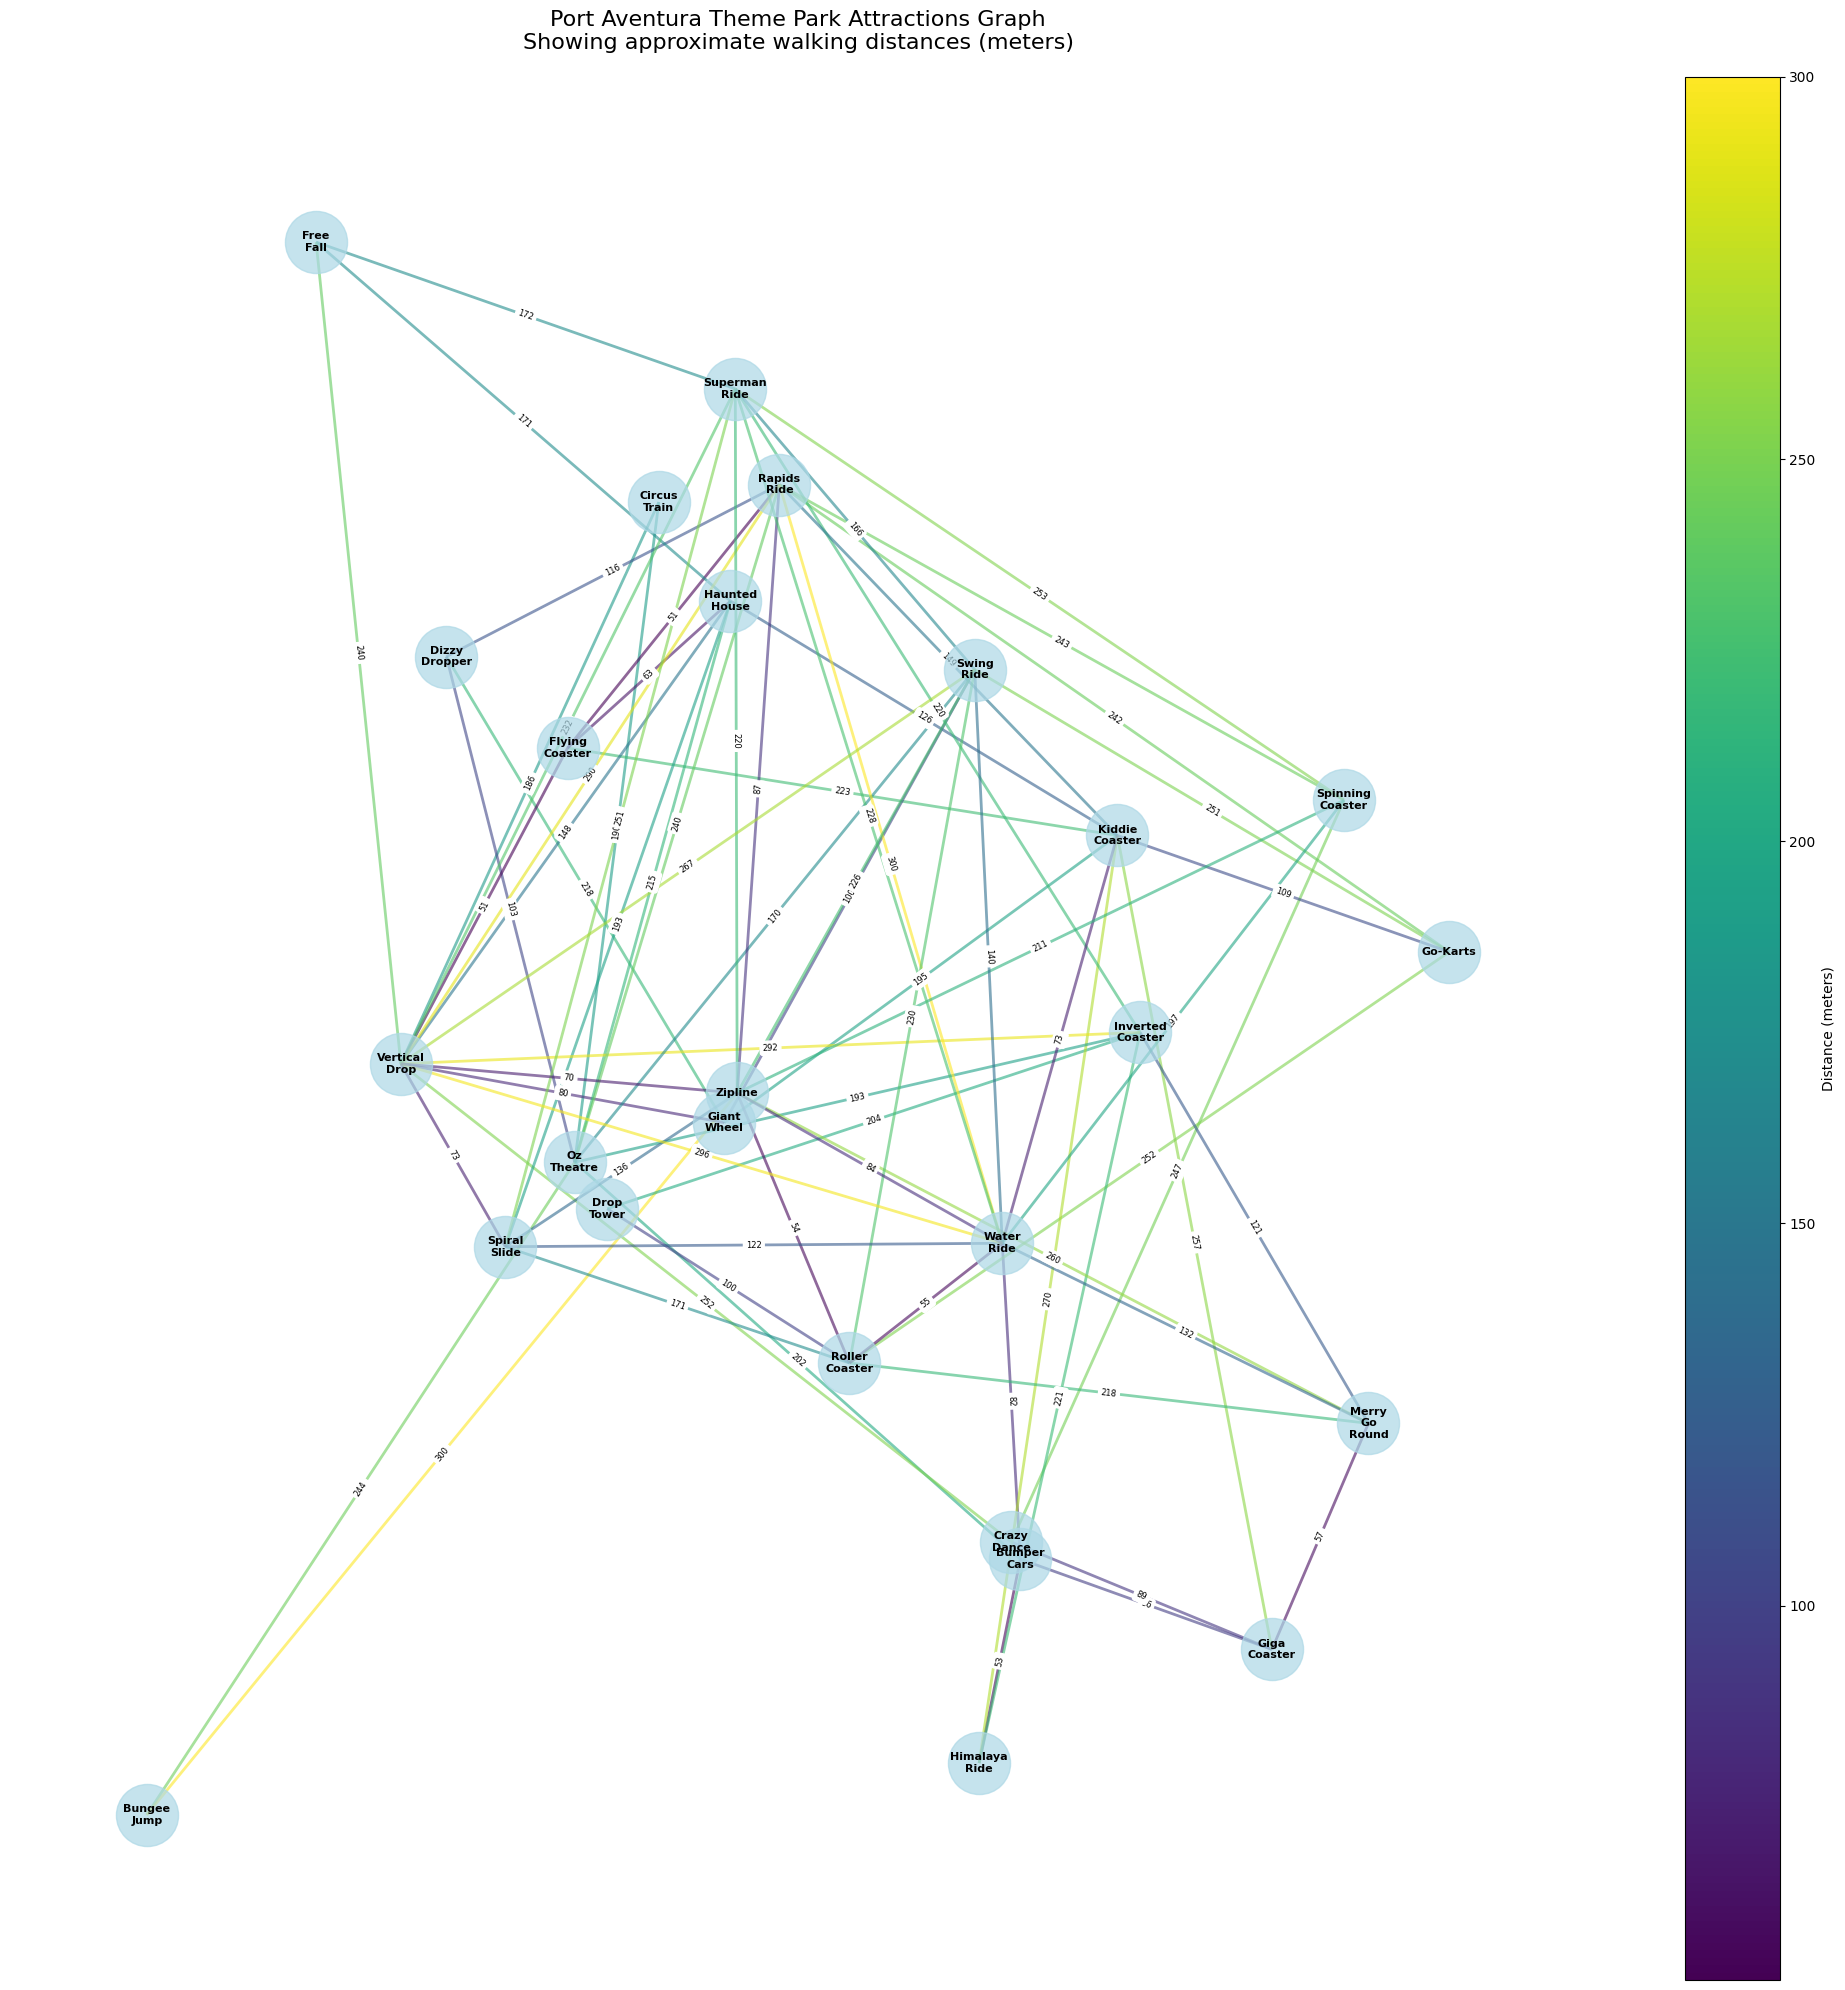

In [25]:
PortAventura_attractions = list(
    link_attractions_df[link_attractions_df["PARK"] == "PortAventura World"][
        "ATTRACTION"
    ]
)

PortAventura_park = ThemeParkGraph(PortAventura_attractions)

for attr1, attr2, distance in essential_distances:
    if attr1 and attr2 in PortAventura_attractions:  # Exclude Tivoli Gardens
        PortAventura_park.add_manual_distance(attr1, attr2, distance)

PortAventura_park.generate_paths()
PortAventura_park.visualize(
    use_distance_layout=True
)  # Set to True for distance-based layout

## Make the pathing methodology

In [26]:
def evaluate_itinerary(
    itinerary,
    start_time,
    waiting_df,
    overlapping_visitors,
    theme_park,
    user_preferences,
):
    """
    Evaluate a given itinerary based on predicted wait times, travel distance, and visitor load.
    """
    current_time = start_time
    total_wait_time = 0
    total_distance = 0
    total_crowd_penalty = 0
    schedule = []

    for i, attraction in enumerate(itinerary):
        # Predict wait time based on arrival time
        predicted_wait_time = predict_wait_time(attraction, current_time, waiting_df)

        # Get ride duration
        ride_duration = get_ride_duration(attraction, waiting_df)

        # Compute crowd penalty (number of overlapping visitors also likely to visit this attraction)
        crowd_penalty = get_crowd_penalty(attraction, overlapping_visitors)

        # Compute distance to next attraction
        if i > 0:
            travel_time = get_travel_time(itinerary[i - 1], attraction, theme_park)
        else:
            travel_time = 0

        # Update total metrics
        total_wait_time += predicted_wait_time
        total_distance += travel_time
        total_crowd_penalty += crowd_penalty

        # Add to the schedule
        next_travel_time = (
            get_travel_time(attraction, itinerary[i + 1], theme_park)
            if i < len(itinerary) - 1
            else 0
        )
        departure_time = current_time + (predicted_wait_time + ride_duration) / 60

        schedule.append(
            {
                "attraction": attraction,
                "arrival_time": round(current_time, 2),
                "wait_time": predicted_wait_time,
                "ride_duration": ride_duration,
                "departure_time": round(departure_time, 2),
                "travel_time_to_next": math.ceil(
                    next_travel_time
                ),  # Assign travel time to next attraction
            }
        )

        # Update current time
        current_time += (
            predicted_wait_time + ride_duration + math.ceil(travel_time)
        ) / 60  # Convert minutes to hours

    # Compute overall score using a weighted approach (Pareto-inspired)

    score = compute_score(
        total_wait_time,
        total_distance,
        total_crowd_penalty,
        itinerary,
        list(new_visitor["preferences"]),
    )

    return schedule, score


def predict_wait_time(attraction, arrival_time, waiting_df):
    """
    Estimate the wait time for an attraction based on the visitor's arrival time.
    """
    wait_times = waiting_df[(waiting_df["ENTITY_DESCRIPTION_SHORT"] == attraction)]
    wait_times = wait_times.sort_values(by="DEB_TIME")

    closest_time = wait_times.iloc[
        (wait_times["DEB_TIME_HOUR"] - arrival_time).abs().argsort()[:1]
    ]
    return (
        closest_time["WAIT_TIME_MAX"].values[0]
        if not closest_time["WAIT_TIME_MAX"].values[0] == 0
        else 2
    )  # Default to 10 min


def get_ride_duration(attraction, waiting_df):
    ride_time = waiting_df[waiting_df["ENTITY_DESCRIPTION_SHORT"] == attraction][
        "UP_TIME"
    ]
    return (
        ride_time.values[0] if not ride_time.values[0] == 0 else 5
    )  # Default to 5 min


def get_travel_time(attraction1, attraction2, theme_park):
    """
    Get travel time between two attractions.
    """
    distance = theme_park.get_distance(attraction1, attraction2)
    travel_time = distance / 100
    return travel_time if travel_time >= 1 else 1


def get_crowd_penalty(attraction, overlapping_visitors):
    """
    Compute a penalty based on the number of other visitors likely to visit this attraction.
    """
    return overlapping_visitors[
        (overlapping_visitors["ride_preference_1"] == attraction)
        | (overlapping_visitors["ride_preference_2"] == attraction)
        | (overlapping_visitors["ride_preference_3"] == attraction)
    ].shape[0]


def compute_score(wait_time, distance, crowd_penalty, itinerary, user_preferences):
    """
    Compute a weighted score balancing waiting time, distance, crowd management, and user preferences.
    """
    w_wait = -1  # Negative weight for wait time (lower is better)
    w_distance = -0.5  # Negative weight for distance (lower is better)
    w_crowd = -2  # Higher penalty for crowded attractions
    w_pref = 3  # Positive weight for visiting top preferences first

    # Calculate preference score (higher if preferred attractions appear earlier in the list)
    preference_score = 0
    for index, attraction in enumerate(itinerary):
        if attraction == user_preferences[0]:  # First choice, highest boost
            preference_score += 3
        elif attraction == user_preferences[1]:  # Second choice, medium boost
            preference_score += 2
        elif attraction == user_preferences[2]:  # Third choice, lowest boost
            preference_score += 1

    return (
        w_wait * wait_time
        + w_distance * distance
        + w_crowd * crowd_penalty
        + w_pref * preference_score
    )


def optimize_schedule(new_visitor, synthetic_users, theme_park, waiting_df):
    """
    Optimize a visitor's itinerary based on predicted wait times, distance, and crowd management.
    """
    overlapping_visitors = synthetic_users[
        (synthetic_users["entry_time"] <= new_visitor["exit_time"])
        & (synthetic_users["exit_time"] >= new_visitor["entry_time"])
    ]

    # Generate all permutations of the preferred attractions
    attraction_permutations = list(itertools.permutations(new_visitor["preferences"]))

    best_schedule = None
    best_score = float("-inf")

    for itinerary in attraction_permutations:
        schedule, score = evaluate_itinerary(
            itinerary,
            new_visitor["entry_time"],
            waiting_df,
            overlapping_visitors,
            theme_park,
            new_visitor["preferences"],
        )

        if score > best_score:
            best_schedule = schedule
            best_score = score

    return best_schedule

In [27]:
# FIX SOME INPUTS
entry_time = 12
exit_time = 16  # these are inputs on the streamlit

preferences = ["Circus Train", "Crazy Dance", "Dizzy Dropper"]

new_visitor = {
    "preferences": [preferences[0], preferences[1], preferences[2]]
    if len(preferences) >= 3
    else preferences,
    "entry_time": entry_time,
    "exit_time": exit_time,
}


In [28]:
synthetic_visitors_df

,entry_time,exit_time,ride_preference_1,ride_preference_2,ride_preference_3
0,12,16,Himalaya Ride,Merry Go Round,Giga Coaster
1,10,15,Spinning Coaster,Merry Go Round,Flying Coaster
2,11,15,Giga Coaster,Flying Coaster,Circus Train
3,13,18,Rapids Ride,Kiddie Coaster,Flying Coaster
4,10,14,Kiddie Coaster,Water Ride,Bumper Cars
...,...,...,...,...,...
49995,10,17,Merry Go Round,Go-Karts,Flying Coaster
49996,11,15,Merry Go Round,Haunted House,Kiddie Coaster
49997,10,17,Himalaya Ride,Merry Go Round,Flying Coaster
49998,11,17,Circus Train,Water Ride,Spiral Slide


In [29]:
optimized_schedule = optimize_schedule(
    new_visitor, synthetic_visitors_df, PortAventura_park, wait_times_df
)

In [30]:
optimized_schedule

[{'attraction': 'Circus Train',
  'arrival_time': 12,
  'wait_time': 2,
  'ride_duration': 5,
  'departure_time': 12.12,
  'travel_time_to_next': 3},
 {'attraction': 'Crazy Dance',
  'arrival_time': 12.12,
  'wait_time': 2,
  'ride_duration': np.int64(15),
  'departure_time': np.float64(12.4),
  'travel_time_to_next': 3},
 {'attraction': 'Dizzy Dropper',
  'arrival_time': np.float64(12.42),
  'wait_time': 2,
  'ride_duration': np.int64(15),
  'departure_time': np.float64(12.7),
  'travel_time_to_next': 0}]

### Optimising schedule where you fill in the other time with rides that aren't that busy 

In [31]:
def evaluate_itinerary(
    itinerary,
    start_time,
    waiting_df,
    date,
    overlapping_visitors,
    theme_park,
    user_preferences,
    end_time,
):
    # Isolate the date of interest
    waiting_df = waiting_df[pd.to_datetime(waiting_df["WORK_DATE"]).dt.date == date]

    current_time = start_time
    total_wait_time = 0
    total_distance = 0
    total_crowd_penalty = 0
    schedule = []

    for i, attraction in enumerate(itinerary):
        # times for each attraction
        predicted_wait_time = predict_wait_time(attraction, current_time, waiting_df)
        ride_duration = get_ride_duration(attraction, waiting_df)
        crowd_penalty = get_crowd_penalty(attraction, overlapping_visitors)
        travel_time = (
            get_travel_time(itinerary[i - 1], attraction, theme_park) if i > 0 else 0
        )

        total_wait_time += predicted_wait_time
        total_distance += travel_time
        total_crowd_penalty += crowd_penalty

        departure_time = current_time + (predicted_wait_time + ride_duration) / 60
        next_travel_time = (
            get_travel_time(attraction, itinerary[i + 1], theme_park)
            if i < len(itinerary) - 1
            else 0
        )

        schedule.append(
            {
                "attraction": attraction,
                "arrival_time": round(current_time, 2),
                "wait_time": predicted_wait_time,
                "ride_duration": ride_duration,
                "departure_time": round(departure_time, 2),
                "travel_time_to_next": math.ceil(next_travel_time),
            }
        )

        current_time += (
            predicted_wait_time + ride_duration + math.ceil(travel_time)
        ) / 60

    # Fill remaining time with low-wait attractions
    schedule = fill_gaps(schedule, current_time, end_time, waiting_df, theme_park)

    score = compute_score(
        total_wait_time,
        total_distance,
        total_crowd_penalty,
        itinerary,
        user_preferences,
    )

    return schedule, score


def fill_gaps(schedule, current_time, end_time, waiting_df, theme_park):
    available_time = end_time - current_time
    if available_time > 0.25 or available_time < -0.25:
        low_wait_attractions = get_low_wait_time_attractions(
            waiting_df, current_time, available_time
        )

        for attraction in low_wait_attractions:
            wait_time = predict_wait_time(attraction, current_time, waiting_df)
            ride_duration = get_ride_duration(attraction, waiting_df)
            travel_time = (
                get_travel_time(schedule[-1]["attraction"], attraction, theme_park)
                if schedule
                else 0
            )

            if current_time + (wait_time + ride_duration + travel_time) / 60 > end_time:
                break

            departure_time = current_time + (wait_time + ride_duration) / 60
            schedule.append(
                {
                    "attraction": attraction,
                    "arrival_time": round(current_time, 2),
                    "wait_time": wait_time,
                    "ride_duration": ride_duration,
                    "departure_time": round(departure_time, 2),
                    "travel_time_to_next": 0,
                }
            )
            current_time = departure_time
    return schedule


def get_low_wait_time_attractions(waiting_df, current_time, available_time):
    filtered = waiting_df[
        (waiting_df["DEB_TIME_HOUR"] >= current_time)
        & (waiting_df["WAIT_TIME_MAX"] < 10)
    ]
    return filtered.sort_values("WAIT_TIME_MAX")["ENTITY_DESCRIPTION_SHORT"].tolist()


def optimize_schedule(new_visitor, synthetic_users, theme_park, waiting_df, date):
    overlapping_visitors = synthetic_users[
        (synthetic_users["entry_time"] <= new_visitor["exit_time"])
        & (synthetic_users["exit_time"] >= new_visitor["entry_time"])
    ]

    attraction_permutations = list(itertools.permutations(new_visitor["preferences"]))
    best_schedule, best_score = None, float("-inf")

    for itinerary in attraction_permutations:
        schedule, score = evaluate_itinerary(
            itinerary,
            new_visitor["entry_time"],
            waiting_df,
            date,
            overlapping_visitors,
            theme_park,
            new_visitor["preferences"],
            new_visitor["exit_time"],
        )

        if score > best_score:
            best_schedule, best_score = schedule, score

    return best_schedule

In [33]:
# This is the date you enter on the streamlit app
date = datetime.date(2022, 5, 22)

# Ensure 'WORK_DATE' column is in datetime format
wait_times_df["WORK_DATE"] = pd.to_datetime(wait_times_df["WORK_DATE"])

# Run optimization
optimized_schedule = optimize_schedule(
    new_visitor, synthetic_visitors_df, PortAventura_park, wait_times_df, date
)


In [34]:
new_visitor

{'preferences': ['Circus Train', 'Crazy Dance', 'Dizzy Dropper'],
 'entry_time': 12,
 'exit_time': 16}

In [35]:
optimized_schedule

[{'attraction': 'Crazy Dance',
  'arrival_time': 12,
  'wait_time': 2,
  'ride_duration': 5,
  'departure_time': 12.12,
  'travel_time_to_next': 3},
 {'attraction': 'Circus Train',
  'arrival_time': 12.12,
  'wait_time': np.int64(5),
  'ride_duration': np.int64(15),
  'departure_time': np.float64(12.45),
  'travel_time_to_next': 2},
 {'attraction': 'Dizzy Dropper',
  'arrival_time': np.float64(12.5),
  'wait_time': np.int64(30),
  'ride_duration': np.int64(15),
  'departure_time': np.float64(13.25),
  'travel_time_to_next': 0},
 {'attraction': 'Oz Theatre',
  'arrival_time': np.float64(13.28),
  'wait_time': np.int64(15),
  'ride_duration': 5,
  'departure_time': np.float64(13.62),
  'travel_time_to_next': 0},
 {'attraction': 'Free Fall',
  'arrival_time': np.float64(13.62),
  'wait_time': np.int64(50),
  'ride_duration': 5,
  'departure_time': np.float64(14.53),
  'travel_time_to_next': 0},
 {'attraction': 'Gondola',
  'arrival_time': np.float64(14.53),
  'wait_time': np.int64(5),
  '

## now sample 200 people

In [36]:
sampled_visitors = synthetic_visitors_df.sample(n=100, replace=True).reset_index(
    drop=True
)

sampled_visitors_dict = sampled_visitors.to_dict(orient="records")

In [37]:
sampled_visitors_dict

[{'entry_time': 12,
  'exit_time': 16,
  'ride_preference_1': 'Flying Coaster',
  'ride_preference_2': 'Drop Tower',
  'ride_preference_3': 'Spinning Coaster'},
 {'entry_time': 13,
  'exit_time': 18,
  'ride_preference_1': 'Go-Karts',
  'ride_preference_2': 'Dizzy Dropper',
  'ride_preference_3': 'Merry Go Round'},
 {'entry_time': 13,
  'exit_time': 18,
  'ride_preference_1': 'Flying Coaster',
  'ride_preference_2': 'Bungee Jump',
  'ride_preference_3': 'Giant Wheel'},
 {'entry_time': 10,
  'exit_time': 16,
  'ride_preference_1': 'Flying Coaster',
  'ride_preference_2': 'Spiral Slide',
  'ride_preference_3': 'Zipline'},
 {'entry_time': 11,
  'exit_time': 17,
  'ride_preference_1': 'Merry Go Round',
  'ride_preference_2': 'Merry Go Round',
  'ride_preference_3': 'Spiral Slide'},
 {'entry_time': 11,
  'exit_time': 17,
  'ride_preference_1': 'Circus Train',
  'ride_preference_2': 'Water Ride',
  'ride_preference_3': 'Merry Go Round'},
 {'entry_time': 14,
  'exit_time': 18,
  'ride_prefere

In [38]:
# all_schedules = []
# for visitor in sampled_visitors_dict:
#     visitor["preferences"] = [visitor["ride_preference_1"], visitor["ride_preference_2"], visitor["ride_preference_3"]]
#     optimized_schedule = optimize_schedule(visitor, synthetic_visitors_df, PortAventura_park, wait_times_df, date)

#     for event in optimized_schedule:
#         all_schedules.append({
#             "attraction": event["attraction"],
#             "arrival_time": event["arrival_time"],
#             "departure_time": event["departure_time"]
#         })

# schedule_df = pd.DataFrame(all_schedules)

In [39]:
# schedule_df.to_csv('data/pathing_scheduled.csv')

In [40]:
schedule_df = pd.read_csv("data/pathing_scheduled.csv")

#### Load the capacities so we can normalise our pathing by capacity

In [41]:
capacity_df = pd.read_csv("data/ride_capacity.csv")

In [42]:
capacity_df

,ENTITY_DESCRIPTION_SHORT,CAPACITY
0,Bumper Cars,251.467785
1,Bungee Jump,301.481387
2,Circus Train,344.244610
3,Crazy Dance,246.720025
4,Dizzy Dropper,211.443284
5,Drop Tower,138.905245
6,Flying Coaster,747.595100
7,Free Fall,133.049327
8,Giant Wheel,500.447000
9,Giga Coaster,695.078490


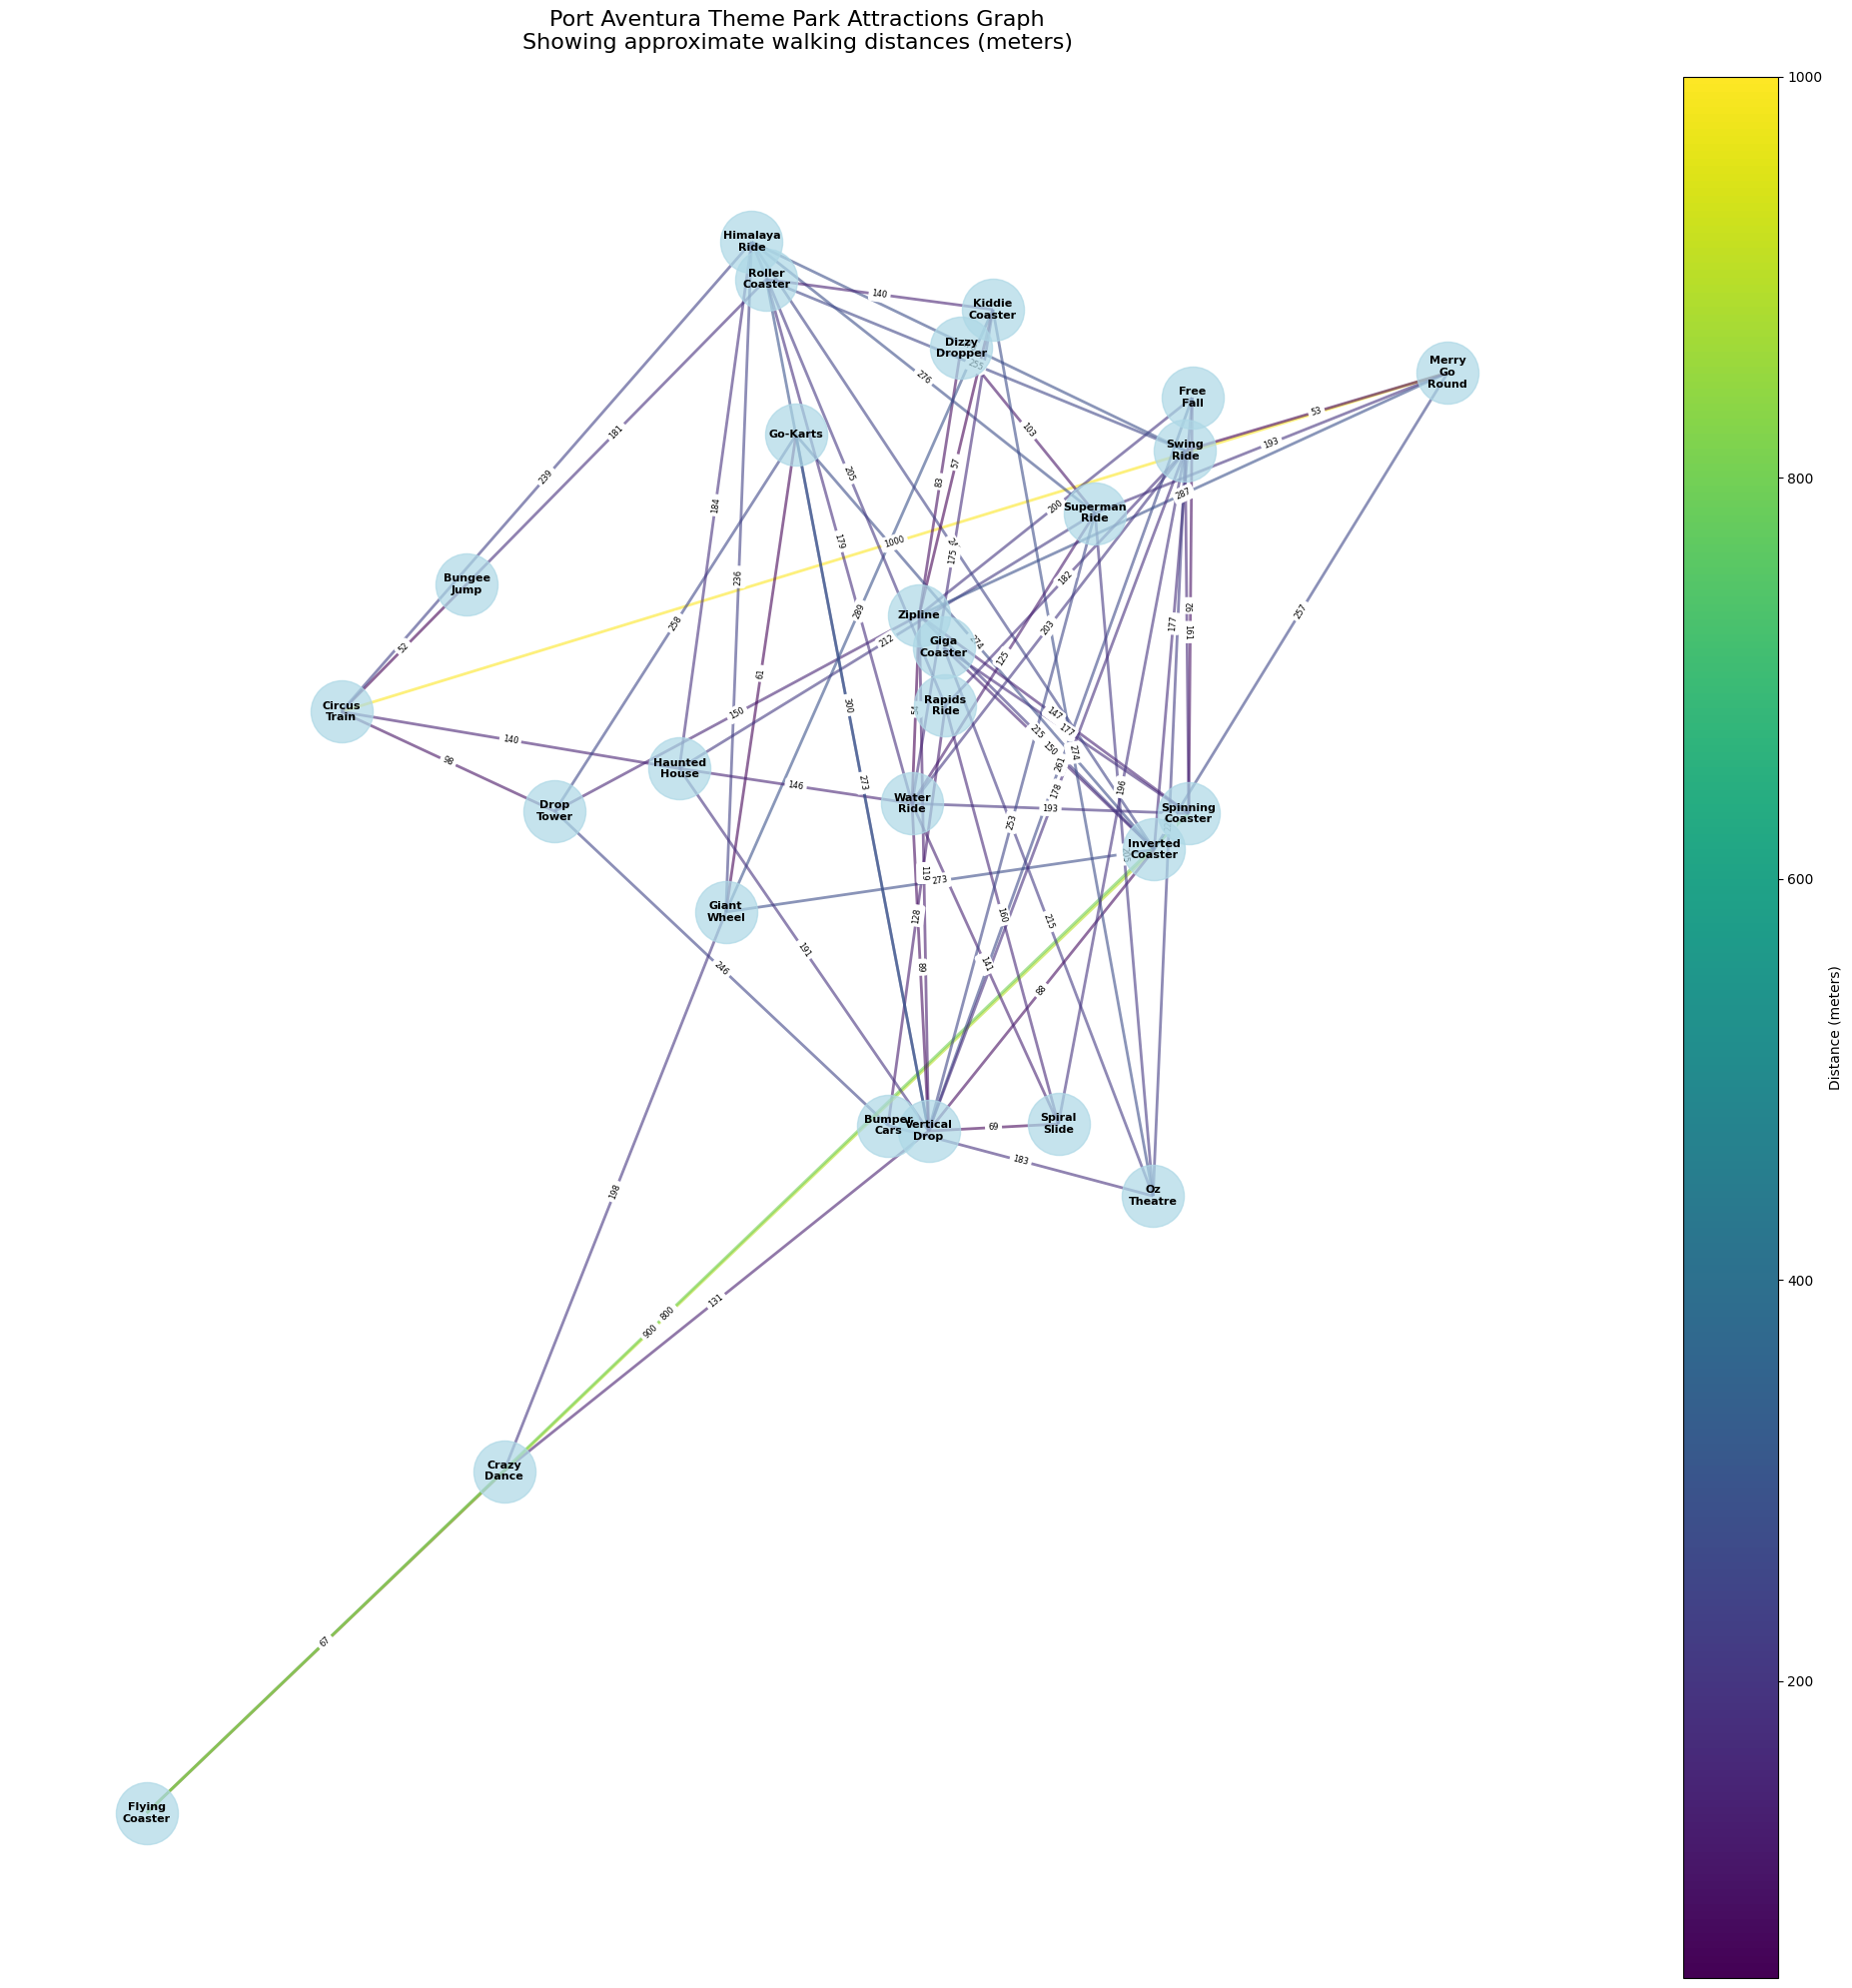

In [46]:
# Normalize the visitor count by the capacity of each attraction
capacity_dict = dict(
    zip(capacity_df["ENTITY_DESCRIPTION_SHORT"], capacity_df["CAPACITY"])
)


# Function to convert decimal hours to "HH:MM" format
def decimal_to_time(decimal_time):
    hours = int(decimal_time)
    minutes = int((decimal_time - hours) * 60)
    return f"{hours:02}:{minutes:02}"  # Format as HH:MM


PortAventura_attractions = list(
    link_attractions_df[link_attractions_df["PARK"] == "PortAventura World"][
        "ATTRACTION"
    ]
)
PortAventura_park = ThemeParkGraph(PortAventura_attractions)

# Add manual distances
for attr1, attr2, distance in essential_distances:
    if attr1 and attr2 in PortAventura_attractions:  # Exclude Tivoli Gardens
        PortAventura_park.add_manual_distance(attr1, attr2, distance)

# Generate paths
PortAventura_park.generate_paths()

# Get the layout from the visualize method
fig, pos_dict = PortAventura_park.visualize(use_distance_layout=True)

# Now you can use pos_dict for your animation
attractions = list(capacity_df["ENTITY_DESCRIPTION_SHORT"].unique())

x = [pos_dict[node][0] for node in attractions]
y = [pos_dict[node][1] for node in attractions]


# Create edge trace (static, no labels or numbers)
edge_trace = go.Scatter(
    x=sum(
        [
            [pos_dict[edge[0]][0], pos_dict[edge[1]][0], None]
            for edge in PortAventura_park.G.edges
        ],
        [],
    ),
    y=sum(
        [
            [pos_dict[edge[0]][1], pos_dict[edge[1]][1], None]
            for edge in PortAventura_park.G.edges
        ],
        [],
    ),
    mode="lines",
    line=dict(width=1, color="gray"),
    hoverinfo="none",  # Prevents hover text on edges
)

# Generate frames for animation
frames = []
time_intervals = np.arange(10, 19, 0.25)

for time in time_intervals:
    # Count visitors at each attraction at this time
    active_visitors = schedule_df[
        (schedule_df["arrival_time"] <= time) & (schedule_df["departure_time"] >= time)
    ]

    node_sizes = []
    node_labels = []
    for node in attractions:
        visitor_count = active_visitors[active_visitors["attraction"] == node].shape[0]
        normalized_size = visitor_count / capacity_dict[node]  # Normalize by capacity
        scaled_size = normalized_size * 100  # Scale the size
        node_sizes.append(scaled_size)
        node_labels.append(f"{node}: {visitor_count}")  # Only append labels to nodes

    formatted_time = decimal_to_time(time)

    # Frame only updates node positions and labels, NOT edges
    frames.append(
        go.Frame(
            data=[
                go.Scatter(
                    x=[pos_dict[node][0] for node in attractions],
                    y=[pos_dict[node][1] for node in attractions],
                    mode="markers+text",
                    marker=dict(size=node_sizes, color="blue", opacity=0.7),
                    text=node_labels,  # Ensure only nodes have labels
                    textposition="top center",
                    hoverinfo="text",
                )
            ],
            name=formatted_time,  # Use formatted time
        )
    )

# Initialize figure with only edge trace (nodes appear via animation)
fig = go.Figure(
    data=[edge_trace],  # Keep only edges static initially
    layout=go.Layout(
        title="Visitor Distribution Over Time",
        width=1200,
        height=800,
        updatemenus=[
            {
                "buttons": [
                    {
                        "args": [
                            None,
                            {
                                "frame": {"duration": 200, "redraw": True},
                                "fromcurrent": True,
                            },
                        ],
                        "label": "Play",
                        "method": "animate",
                    },
                    {
                        "args": [
                            [None],
                            {
                                "frame": {"duration": 0, "redraw": True},
                                "mode": "immediate",
                                "transition": {"duration": 0},
                            },
                        ],
                        "label": "Pause",
                        "method": "animate",
                    },
                ],
                "direction": "left",
                "pad": {"r": 10, "t": 87},
                "showactive": False,
                "type": "buttons",
                "x": 0.1,
                "xanchor": "right",
                "y": 0,
                "yanchor": "top",
            }
        ],
        sliders=[
            {
                "active": 0,
                "yanchor": "top",
                "xanchor": "left",
                "currentvalue": {"prefix": "Time: ", "font": {"size": 20}},
                "pad": {"b": 10, "t": 50},
                "len": 0.9,
                "x": 0.1,
                "y": -0.1,
                "steps": [
                    {
                        "args": [
                            [f.name],
                            {
                                "frame": {"duration": 0, "redraw": True},
                                "mode": "immediate",
                            },
                        ],
                        "label": f.name,
                        "method": "animate",
                    }
                    for f in frames
                ],
            }
        ],
    ),
    frames=frames,  # Ensure frames only update nodes
)

fig.show()
